During this lab we will take a look at the jMetalPy platform, run the first simple heuristic algorithm (local search) and play with different methods of visualization and testing statistical significance.

First let us install what is needed - jmetalpy and scikit-posthocs


In [1]:
%pip install jmetalpy
%pip install scikit-posthocs

     |████████████████████████████████| 110 kB 4.4 MB/s 
  Created wheel for jmetalpy: filename=jmetalpy-1.5.5-py3-none-any.whl size=196211 sha256=f8bcc2f7b42a607b98ea6185ac46e19c480446ed25b489a9ce9541d062115a0c
  Stored in directory: /root/.cache/pip/wheels/ca/8a/fd/c7b0b43039ee307e366569834484b5aa51ff81d609288dfcd2
Successfully built jmetalpy
     |████████████████████████████████| 43 kB 1.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37903 sha256=95b8400811a55e05bacc1614f4e840ba9c1bcdb18903636ffee96c0b7e06fae2
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


And now let us take look at the jMetalPy.... finally we can run the algorithm based on this framework.



In [15]:
from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator import SimpleRandomMutation
from jmetal.problem.singleobjective.unconstrained import Rastrigin,Sphere
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file
from jmetal.util.termination_criterion import StoppingByEvaluations

problem = Rastrigin(10)

max_evaluations = 100

algorithm = LocalSearch(
    problem=problem,
    mutation=SimpleRandomMutation(1.0 / problem.number_of_variables),
    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
)

algorithm.run()
result = algorithm.get_result()

print('Algorithm: ' + algorithm.get_name())
print('Problem: ' + problem.get_name())
print('Solution: ' + str(result.variables))
print('Fitness:  ' + str(result.objectives[0]))
print('Computing time: ' + str(algorithm.total_computing_time))





Algorithm: LS
Problem: Rastrigin
Solution: [0.16680119366416868, -1.8238912163783527, -0.9374950464021925, -0.18743165203790024, -0.024307762359423002, -0.1290686868526496, -2.9093066169772808, -0.29494703299164104, 2.141307266800178, -0.9962793459240853]
Fitness:  57.16188080879668
Computing time: 0.00944375991821289


This is of course a heuristic algorithm, let us run it many times and show the dispersion of the outcome.


[57.152963822119204, 90.55756620937052, 59.01478129909478, 44.81753237954823, 57.22648142820603, 46.043561231365956, 56.28682553705573, 42.654212672970615, 50.166880852698554, 40.27354057447678, 76.43552353527005, 70.0100694589506, 80.73205825728603, 73.61100982355096, 31.15889422412049, 45.973921282221575, 36.51016706229456, 47.31500580371359, 66.2956381529271, 54.790219180335356, 63.67150326593608, 43.85961219744726, 43.73171922557697, 51.8436148805297, 58.62648282498749, 75.72557016546244, 69.61663062088542, 76.13433821701298, 59.865254391301484, 60.68017305573469]


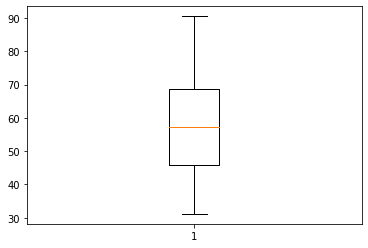

In [19]:
series = []
for x in range(30):
  algorithm = LocalSearch(
      problem=problem,
      mutation=SimpleRandomMutation(1.0 / problem.number_of_variables),
      termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
  )
  algorithm.run()
  result = algorithm.get_result().objectives[0]
  series.append(result)

print(series)

import matplotlib.pyplot as plt 
import numpy as np 
  
fig = plt.figure() 
  
# Creating plot 
plt.boxplot(series) 
  
# show plot 
plt.show() 

It would be nice to see the progress of the algorithm. First let us take a look at a toy  - a progress bar.

In [20]:

from jmetal.util.observer import ProgressBarObserver

max_evaluations = 100000
algorithm = LocalSearch(
      problem=problem,
      mutation=SimpleRandomMutation(1.0 / problem.number_of_variables),
      termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
      )
basic = ProgressBarObserver(max=max_evaluations)
algorithm.observable.register(observer=basic)

algorithm.run()









/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Progress: 100%|##########| 100000/100000 [00:11<00:00, 8485.12it/s]


However it would be better to take a closer look at what is happening in the algorithm - what is the value of the best fitness in every step, or at certain moments in time. We have to implement a dedicated observer - mind that it uses a local variable, thus it is a quick and dirty solution....

In [ ]:
from jmetal.core.observer import Observer
import logging

data = []


class DataObserver(Observer):

    def __init__(self, frequency: float = 1.0) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives
            data.append(fitness[0])


max_evaluations = 10000
algorithm = LocalSearch(
      problem=problem,
      mutation=SimpleRandomMutation(1.0 / problem.number_of_variables),
      termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
      )
dataobserver = DataObserver(frequency=1.0)
algorithm.observable.register(observer=dataobserver)

algorithm.run()

print(data)



import matplotlib.pyplot as plt 
import numpy as np 
  
fig = plt.figure() 
  
# Creating plot 
plt.plot(data)
  
# show plot 
plt.show() 


Now let us take a proper look at the progress of the algorithm. Let us repeat it many times, and draw an appropriate box and whiskers plot for every moment in time, observing the best fitness.

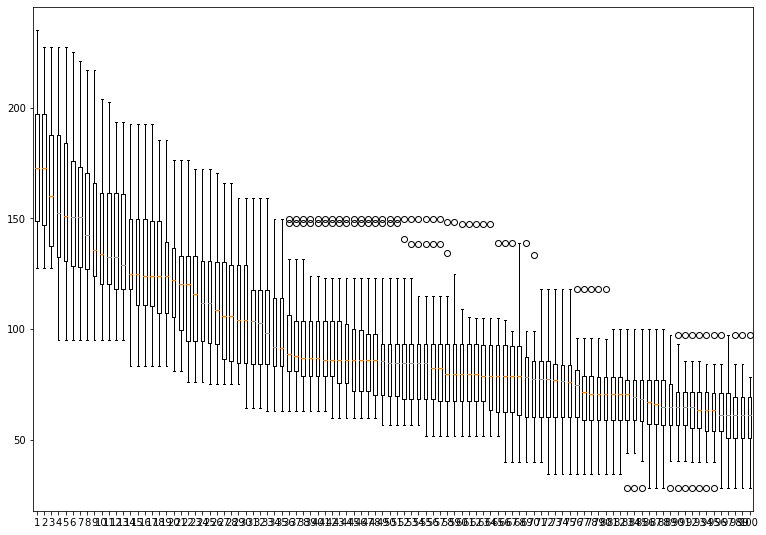

In [27]:
alldata = []
for x in range(30):
  data = []
  max_evaluations = 100
  algorithm = LocalSearch(
        problem=problem,
        mutation=SimpleRandomMutation(1.0 / problem.number_of_variables),
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
        )
  dataobserver = DataObserver(frequency=1.0)
  algorithm.observable.register(observer=dataobserver)

  algorithm.run()
  alldata.append(data)

#transpose!
numpy_array = np.array(alldata)
transpose = numpy_array.T
transpose_list = transpose.tolist()

#print(transpose_list)

  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
bp = ax.boxplot(transpose_list) 
 
# show plot 
plt.show()

Kruskall Wallis is a nonparametric statistical test for comparing the distribution of the random variables. It will show whether a certain sample from our tested set (at least two samples are required) differs from others.

Afterwards we can use Dunn test to check the relations between all the samples tested.





In [31]:
import scikit_posthocs as sp
from scipy import stats

#perform Wilcoxon Test 
print(stats.wilcoxon(transpose_list[50],transpose_list[51]))


#perform Kruskal-Wallis Test 
print(stats.kruskal(transpose_list[0],transpose_list[1],transpose_list[99]))


# perform dunn test
sp.posthoc_dunn([transpose_list[0],transpose_list[1],transpose_list[99],transpose_list[30]], p_adjust = 'holm')

WilcoxonResult(statistic=0.0, pvalue=0.10880943004054568)
KruskalResult(statistic=59.41444625568068, pvalue=1.254055978394288e-13)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning:

Sample size too small for normal approximation.



,1,2,3,4
1,1.000000e+00,7.950151e-01,1.481087e-15,0.000007
2,7.950151e-01,1.000000e+00,1.035589e-14,0.000017
3,1.481087e-15,1.035589e-14,1.000000e+00,0.001331
4,6.559755e-06,1.739793e-05,1.330908e-03,1.000000


And now let us focus on the report. Please realize them during the lab class and perhaps later - please prepare short reports (outcomes, graphs) and send them to me olekb@agh.edu.pl. The report should be formatted in PDF. The reports should contain snippets of code, graphs and a very short discussion of the results (e.g. every graph or result should be commented). One report should be prepared by a group consisting of 2 max 3 persons. Names of all persons should be included into report.

1. Please implement simple algorithms simulating tossing a coin (0 is for tails and 1 is returned for heads):
- fair coin (probability 50/50)
- unfair coin (e.g. 20/80)
- unfair coin (e.g. 90/10)
- another two unfair coin quite close to one of the previous ones (e.g. 51/49 and 24/76)
2. Please run the experiments for the coin tossers (they should be repeated 30 times) and draw box and whisker plot for comparing the three means of the final results coming from different algorithms. One mean should come from fair coin, one from unfair etc.
3. Apply the relevant statistical hypotheses testing tools for checking whether the cumulative distribution functions of the samples coming from the experiments are different or not (Kruskal-Wallis + Dunn). Assume first the p-value and comment how you can interprete the result.
4. Write a short report - parameters, graphs and very short discussion, each result/graph should be commented.
